[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

### Chain

- 노드, 엣지, 조건부 엣지를 포함한 간단한 그래프를 구축할 수 있음.
- 이제 기존 LangChain의 구조를 LangGraph를 활용한 Chain 구조로 변환하여 구현 해보고자 함.

#### 목표

다음 4가지 [개념](https://python.langchain.com/v0.2/docs/concepts/)을 결합하여 간단한 체인을 구축

1. [채팅 메시지](https://python.langchain.com/v0.2/docs/concepts/#messages)를 그래프 상태로 사용하기  
2. [채팅 모델](https://python.langchain.com/v0.2/docs/concepts/#chat-models)을 그래프 노드에 사용하기  
3. [도구 바인딩](https://python.langchain.com/v0.2/docs/concepts/#tools)을 채팅 모델에 결합하기  
4. 그래프 노드에서 [도구 호출 실행](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)하기  

![스크린샷: 2024-08-21 오전 9시 24분 03초](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

### Messages

채팅 모델은 대화에서 다양한 역할을 나타내는 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)를 사용할 수 있음

LangChain은 다음과 같은 다양한 메시지 유형을 지원:
- `HumanMessage`: 사용자가 보낸 메시지
- `AIMessage`: 채팅 모델이 생성한 메시지
- `SystemMessage`: 채팅 모델의 동작을 지시하기 위한 메시지 -> 프롬프트
- `ToolMessage`: 도구 호출에서 생성된 메시지

### Message List 생성

각 메시지는 다음과 같은 요소를 포함할 수 있음. 반환된 메시지 값들에서 아래 요소를 Key 값으로 활용하여 Value 추출
- **`content`**: 메시지의 내용
- **`name`**: 선택적으로 메시지 작성자의 이름
- **`response_metadata`**: 선택적으로 메타데이터 딕셔너리 (예: `AIMessage`의 경우 모델 제공자가 채울 수 있음)

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# 메시지 작성 content와 각 메시지의 name만 추가
messages = [AIMessage(content=f"그러니까 당신은 해양 포유류를 연구하고 있다고 말했나요?", name="Model")]  # messages 리스트 정의
messages.append(HumanMessage(content=f"네, 맞습니다.", name="Lance"))  # 사람 메시지 추가
messages.append(AIMessage(content=f"좋습니다, 무엇을 배우고 싶으신가요?", name="Model"))  # AI 응답
messages.append(HumanMessage(content=f"미국에서 범고래를 가장 잘 볼 수 있는 곳에 대해 알고 싶습니다.", name="Lance"))  # 사람 메시지

# 메시지 리스트 출력
for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

그러니까 당신은 해양 포유류를 연구하고 있다고 말했나요?
================================ Human Message =================================
Name: Lance

네, 맞습니다.
================================== Ai Message ==================================
Name: Model

좋습니다, 무엇을 배우고 싶으신가요?
================================ Human Message =================================
Name: Lance

미국에서 범고래를 가장 잘 볼 수 있는 곳에 대해 알고 싶습니다.


### Chat Model

- [채팅 모델](https://python.langchain.com/v0.2/docs/concepts/#chat-models)은 메시지의 순서를 입력으로 사용하며, 위에서 논의한 메시지 유형을 지원

- 사용할 수 있는 [다양한 모델](https://python.langchain.com/v0.2/docs/concepts/#chat-models)이 있음. 해당 예제에서는 OpenAI를 사용

In [4]:
import os, getpass

# `OPENAI_API_KEY`가 설정되어 있는지 확인하고, 설정되지 않은 경우 입력을 요청
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

- 우리는 채팅 모델을 로드하고 메시지 리스트로 호출할 수 있음
- 응답 결과의 타입은 특정 `response_metadata`가 포함된 `AIMessage`

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [6]:
result

AIMessage(content='미국에서 범고래(오르카)를 관찰하기 좋은 곳으로는 주로 태평양 북서부 지역이 추천됩니다. 다음은 주목할 만한 장소들입니다:\n\n1. **워싱턴 주 샌후안 제도(San Juan Islands)**: 이 지역은 범고래 관찰로 유명하며, 특히 프라이데이 하버(Friday Harbor)에서 출발하는 여러 투어가 있습니다. 샌후안 제도 주변의 물은 범고래가 자주 출몰하는 지역입니다.\n\n2. **시애틀 주변**: 워싱턴 주 시애틀 주변의 퓨젓사운드(Puget Sound)에서도 범고래를 볼 수 있습니다. 이 지역에서도 여러 투어가 제공됩니다.\n\n3. **캘리포니아 몬터레이 베이(Monterey Bay)**: 이곳에서도 범고래를 포함한 다양한 해양 생물을 관찰할 수 있습니다. 몬터레이 베이는 해양 생물 다양성이 풍부한 지역입니다.\n\n4. **알래스카**: 알래스카의 남동부 해안과 케치칸(Ketchikan), 주노(Juneau) 근처에서도 범고래를 볼 수 있습니다. 이 지역은 여름철에 범고래가 많이 나타나는 곳 중 하나입니다.\n\n이러한 장소들에서는 범고래를 볼 확률이 높으며, 다양한 투어 옵션을 통해 가까이에서 범고래를 관찰할 수 있습니다. 다만, 자연에서의 동물 관찰은 항상 변동성이 있으므로, 사전에 현지 투어 회사들과 협의하여 가장 좋은 시기와 장소를 선택하는 것이 좋습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 367, 'prompt_tokens': 81, 'total_tokens': 448, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'aud

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 367,
  'prompt_tokens': 81,
  'total_tokens': 448,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_d28bcae782',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

- 도구는 모델이 외부 시스템과 상호 작용할 때 유용(API)

- 외부 시스템(예: API)은 종종 자연어가 아닌 특정 입력 스키마 또는 페이로드를 요구

- API를 도구로 바인딩할 때, 모델은 요구되는 입력 스키마를 인식

- 모델은 사용자의 자연어 입력을 기반으로 도구를 호출하며, 도구의 스키마에 맞는 출력을 반환

- [다수의 LLM 제공자](https://python.langchain.com/v0.1/docs/integrations/chat/)가 도구 호출을 지원하며, LangChain에서 [도구 호출 인터페이스](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)는 간단함.

- 파이썬 `function`을 `ChatModel.bind_tools(function)`에 전달하기만 하면 됨.

![스크린샷: 2024-08-19 오후 7시 46분 28초](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

곱셈 도구(함수) 정의

In [8]:
# 곱셈 함수 정의 -> 2개의 정수형 숫자를 인수로 받음.
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# 위에서 정의한 llm모델에 bind_tools 활용하여 바인딩
# tools는 리스트 형태로 여러개의 도구를 가질 수 있음.
llm_with_tools = llm.bind_tools([multiply])

- 만약 우리가 입력으로 "2 곱하기 3은 무엇인가요?"를 전달하면, 도구 호출이 반환되는 것을 볼 수 있음
- 도구 호출에는 호출할 함수의 이름(name)과 함께 함수의 입력 스키마에 맞는 특정 인수(argument)가 포함

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9gwwanCeAMTXeqh855AVmEan', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 62, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b57d94a7-a3f0-47bf-aef4-778b73849795-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_9gwwanCeAMTXeqh855AVmEan', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 18, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_9gwwanCeAMTXeqh855AVmEan',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

### 메시지를 상태로 사용하기

- 이제 기본 사항을 바탕으로 그래프 상태에서 [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)를 사용할 수 있음

- `MessagesState`라는 상태를 정의하고, 하나의 키 `messages`를 포함하는 `TypedDict`로 설정

- `messages`는 단순히 위에서 정의한 메시지(`HumanMessage` 등)의 리스트

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

# 메시지를 상태로 활용
class MessagesState(TypedDict):
    messages: list[AnyMessage]

### 리듀서 (Reducers)

- 여기서 한가지 문제가 발생함

- 각 노드는 상태 키 `messages`의 새 값을 반환합니다. 그러나 이 새 값은 이전 `messages` 값을 [덮어씀](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers).

- 그래프가 실행되는 동안, 우리는 `messages` 상태 키에 메시지를 **추가**해야 함. -> 덮어쓰는 것이 아님!

- 이를 해결하기 위해 **[리듀서 함수](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)**를 사용

- 리듀서는 상태 업데이트가 수행되는 방식을 지정할 수 있도록 함. **리듀서 함수가 지정되지 않으면, 기본적으로 키에 대한 업데이트는 값을 *덮어쓰는 방식*으로 처리**

- 메시지를 추가하려면, 미리 정의된 `add_messages` 리듀서를 사용할 수 있음. 이는 새로운 메시지를 기존 메시지 리스트에 추가되도록 보장

- `messages` 키를 `add_messages` 리듀서 함수로 주석 처리하여 메타데이터로 간단히 설정하면 됨.

In [12]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # Annotated 타입 활용 : 기본 타입에 추가 메타데이터를 연결할 수 있는 방법

그래프 상태에서 메시지 리스트를 사용하는 것이 매우 일반적이기 때문에, LangGraph에는 미리 정의된 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)가 제공됨

`MessagesState`는 다음과 같이 정의:
- 미리 정의된 단일 `messages` 키를 포함합니다.
- 이 키는 `AnyMessage` 객체의 리스트입니다.
- `add_messages` 리듀서를 사용합니다.

`MessagesState`는 위에서 보여준 것처럼 사용자 지정 `TypedDict`를 정의하는 것보다 간결하기 때문에 주로 사용됨.

In [13]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # 메시지 외에 필요한 키를 추가할 수 있음. (messages는 이미 미리 정의됨)
    pass


- 조금 더 깊이 들어가서, `add_messages` 리듀서가 어떻게 작동하는지 개별적으로 살펴볼 수 있음
- `add_messages` 리듀서는 새로운 메시지를 기존 메시지 리스트에 **추가**하는 방식으로 상태를 업데이트함. 이를 통해 이전 메시지가 덮어쓰여지지 않고, 순차적으로 축적

In [14]:
# 초기 상태
initial_messages = [AIMessage(content="안녕하세요! 무엇을 도와드릴까요?", name="Model"),
                    HumanMessage(content="해양 생물학에 대한 정보를 찾고 있습니다.", name="Lance")
                   ]

# 추가할 새 메시지
new_message = AIMessage(content="물론 도와드릴 수 있습니다. 구체적으로 어떤 점을 알고 싶으신가요?", name="Model")

# 테스트
add_messages(initial_messages, new_message)


[AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, name='Model', id='e38aaa30-2517-49eb-bc2e-a2add8200134'),
 HumanMessage(content='해양 생물학에 대한 정보를 찾고 있습니다.', additional_kwargs={}, response_metadata={}, name='Lance', id='4a9340ca-3da9-4c40-af05-d395a82c399f'),
 AIMessage(content='물론 도와드릴 수 있습니다. 구체적으로 어떤 점을 알고 싶으신가요?', additional_kwargs={}, response_metadata={}, name='Model', id='009042f7-d74d-4d4e-a0f8-9d9591a05c16')]

## 정리

- 정리하자면, LangGraph에서는 이미 `MessagesState` 를 통해서 메시지 상태를 관리할 수 있게 제공하고 있음.
- 메시지 리스트 함수를 정의한 후 `add_messages` 를 통해서 메시지 리스트를 덮어쓰지 않고, 사용자와 AI의 메시지를 지속해서 추가해나갈 수 있음.


### 그래프 사용

- `MessagesState`를 그래프와 함께 사용해보기

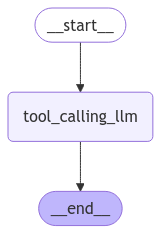

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 노드 정의
def tool_calling_llm(state: MessagesState): # 상태는 메시지 리스트를 상태로 활용
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 그래프 빌드
builder = StateGraph(MessagesState) # 그래프 상태 초기화
builder.add_node("tool_calling_llm", tool_calling_llm) # 노드 추가
builder.add_edge(START, "tool_calling_llm")  # START에서 tool_calling_llm으로 이동
builder.add_edge("tool_calling_llm", END)  # tool_calling_llm에서 END로 이동
graph = builder.compile() # 그래프 컴파일

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


- LLM은 입력이나 작업이 해당 도구가 제공하는 기능을 필요로 한다고 판단할 때 도구를 사용하기로 결정함. 따라서 만약에 입력으로 `안녕하세요!`를 전달하면, LLM은 도구 호출 없이 응답함

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="안녕하세요!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

안녕하세요!
================================== Ai Message ==================================

안녕하세요! 어떻게 도와드릴까요?


- 반대로 도구 호출이 필요하다고 판단되면, 도구를 호출함

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="2와 3을 곱해주세요!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

2와 3을 곱해주세요!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_g1UD4kcSGUxE6Rv1a6r60H4W)
 Call ID: call_g1UD4kcSGUxE6Rv1a6r60H4W
  Args:
    a: 2
    b: 3


In [20]:
messages

{'messages': [HumanMessage(content='2와 3을 곱해주세요!', additional_kwargs={}, response_metadata={}, id='c400a94d-23c7-49a6-bf57-86334b0c92f8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g1UD4kcSGUxE6Rv1a6r60H4W', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 61, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-eae3beec-b3a6-40ef-bfb0-4161679e87ee-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_g1UD4kcSGUxE6Rv1a6r60H4W', 'type': 'tool_call'}], usage_metadata={'input_tokens': 61, 'output_tokens': 18, '